In [1]:
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Load dataset
text_df = pd.read_csv("fake_or_real_news.csv")
text = list(text_df.text.values)
joined_text = " ".join(text)

In [3]:
# Prepare text for tokenization
partial_text = joined_text[:1000000]
tokenizer = RegexpTokenizer(r"\w+")
tokens = tokenizer.tokenize(partial_text.lower())

In [4]:
# Prepare unique tokens and their indices
word_counts = Counter(tokens)
most_common_tokens = word_counts.most_common(5000)  # Keep top 5000 tokens
unique_tokens = [token for token, _ in most_common_tokens]
unique_token_index = {token: index for index, token in enumerate(unique_tokens)}

n_words = 10
input_words = []
next_word = []

In [5]:
# Create input and output sequences
for i in range(len(tokens) - n_words):
    input_words.append(tokens[i:i + n_words])
    next_word.append(tokens[i + n_words])


In [6]:
# Prepare the input data for the LSTM
X = np.zeros((len(input_words), n_words, len(unique_tokens)), dtype=np.uint8)
y = np.zeros((len(next_word), len(unique_tokens)), dtype=np.uint8)


In [7]:

# Populate X and y arrays
for i, words in enumerate(input_words):
    for j, word in enumerate(words):
        if word in unique_token_index:
            X[i, j, unique_token_index[word]] = 1  # One-hot encoding for input
    if next_word[i] in unique_token_index:  # Ensure next word is in index
        y[i, unique_token_index[next_word[i]]] = 1  # One-hot encoding for output


In [8]:
# Model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(n_words, len(unique_tokens)), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(len(unique_tokens)))
model.add(Activation("softmax"))

c:\Users\Kunal Ramesh Pawar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:

# Compile the model
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [10]:
# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [11]:
# Training the model
history = model.fit(X, y, batch_size=256, epochs=1, shuffle=True, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint]).history

531/531 ━━━━━━━━━━━━━━━━━━━━ 195s 355ms/step - accuracy: 0.1268 - loss: 6.3363 - val_accuracy: 0.1448 - val_loss: 6.2909


In [12]:
# Save the trained model and training history
model.save("text_gen_model.keras")
with open("history.p", "wb") as f:
    pickle.dump(history, f)

In [13]:
# Function to predict the next word
def predict_next_word(input_text, n_best):
    input_text = input_text.lower()
    X = np.zeros((1, n_words, len(unique_tokens)))
    for i, word in enumerate(input_text.split()):
        if word in unique_token_index:
            X[0, i, unique_token_index[word]] = 1
            
    predictions = model.predict(X)[0]
    return np.argpartition(predictions, -n_best)[-n_best:]

In [14]:
# Function to generate text
def generate_text(input_text, n_words, creativity=3):
    word_sequence = input_text.split()
    current = 0
    for _ in range(n_words):
        sub_sequence = " ".join(tokenizer.tokenize(" ".join(word_sequence).lower())[current:current+n_words])
        try:
            choice = unique_tokens[random.choice(predict_next_word(sub_sequence, creativity))]
        except:
            choice = random.choice(unique_tokens)
        word_sequence.append(choice)
        current += 1
    return " ".join(word_sequence)

In [15]:
# Example usage of text generation
generated_text1 = generate_text("I will have to look into this thing because I", 10, 10)
print(generated_text1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
I will have to look into this thing because I of of the i be a a be a would


In [16]:
# Example usage of text generation
generated_text1 = generate_text("Sahil is a good boy, but", 10, 5)
print(generated_text1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Sahil is a good boy, but that the would to would would of the to to


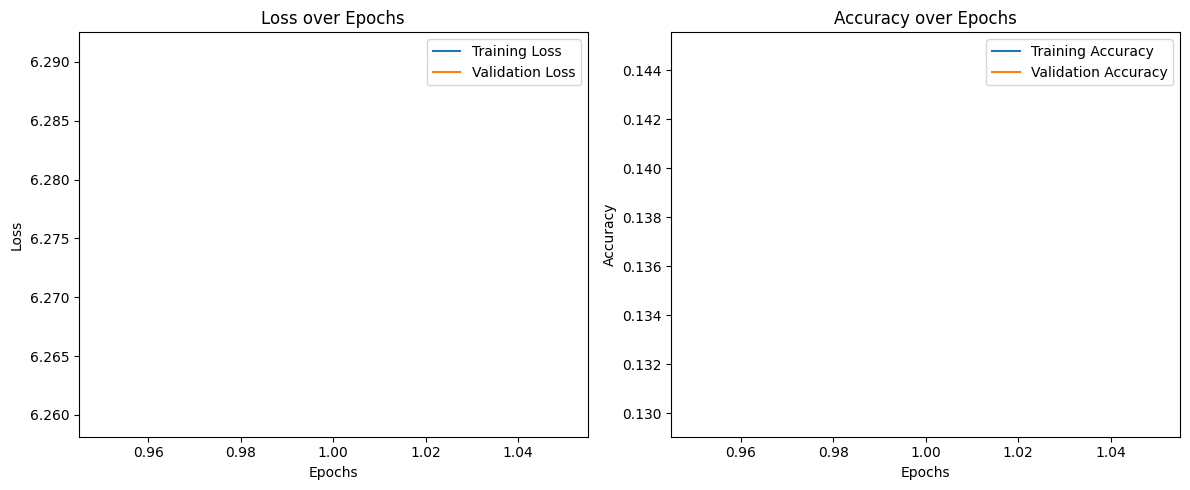

In [17]:
# Plot the learning curve
def plot_learning_curve(history):
    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history.get('accuracy')
    val_accuracy = history.get('val_accuracy')
    
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy (if available)
    if accuracy and val_accuracy:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, label="Training Accuracy")
        plt.plot(epochs, val_accuracy, label="Validation Accuracy")
        plt.title("Accuracy over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the learning curve
plot_learning_curve(history)

In [18]:
# Example usage of text generation
generated_text1 = generate_text("MY name is anupama, but", 10, 5)
print(generated_text1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
MY name is anupama, but of that to that that to would that the that


In [19]:
# Example usage of text generation
generated_text1 = generate_text("Hello", 10, 5)
print(generated_text1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Hello the of the to the to would to to would


In [20]:
# Example usage of text generation
generated_text1 = generate_text("Hello", 10, 5)
print(generated_text1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Hello that would the of that would that to of the


In [21]:
# Example usage of text generation
generated_text1 = generate_text("Hello", 10, 5)
print(generated_text1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Hello to of the to the that the would would the


In [22]:
# Example usage of text generation
generated_text1 = generate_text("sanket is", 10, 5)
print(generated_text1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
sanket is the would that the of would to that that would
